# Network Analysis in GIS

based on osnmx, grapphoper and movingpandas
goals of the tutorial

- basic concepts of network analysis
- routing
- bearing
- isochrones
- GPX format
- mapmatching
- analysis of movements

based on the open data of:
- OpenStreetMap

requirements
- python knowledge
- geopandas
- openstreetmap

status<br/>
“Where's Wally?”

---

# Setup
for this tutorial we will use [OSMnx](https://github.com/gboeing/osmnx) = (openstreetmap + [networkx](https://networkx.org/))

Boeing, G. 2017. "[OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks.](https://geoffboeing.com/publications/osmnx-complex-street-networks/)" *Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004*



... and now we can install OSMnx

In [19]:
try:
    import osmnx  as ox
except ModuleNotFoundError as e:
    !pip install osmnx==1.9.3
    import osmnx  as ox
if ox.__version__ != "1.9.3":
    !pip install -U osmnx==1.9.3
    import osmnx  as ox

... and all the other packages needed for this lecture

In [20]:
try:
    import mapclassify
except ModuleNotFoundError as e:
    !pip install mapclassify
    import mapclassify

if mapclassify.__version__ != "2.6.1":
  !pip install -U mapclassify==2.6.1

In [21]:
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore") 

# Let’s start with OSMnx


In [22]:
import osmnx as ox
import matplotlib.pyplot as plt

## prepare the data

Playing with Venice 


[Venice in Italy](https://www.openstreetmap.org/relation/44230)

In [23]:
place_name = "Venezia, Lido, Venice, Venezia, Veneto, Italy"

.. and we can extract all the streets where it's possible to drive

OSMnx creates a overpass query to ask the data inside the area of name of the city and collect all the [highways](https://wiki.openstreetmap.org/wiki/Key:highway) where a car can move

Eg.<br/>
https://overpass-turbo.eu/s/1nnv

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/mezzolombardo_streets.png)

In [24]:
G = ox.graph_from_place(place_name, network_type='all',simplify=False)

OSMnx transform the data from OpenStreetMap in [graph](https://networkx.org/documentation/stable/reference/introduction.html#graphs) for [networkx](https://networkx.org/)

# Graph Theory
text from [wikipedia](https://en.wikipedia.org/wiki/Graph_theory)



A graph is made up of **vertices** (also called *nodes* or *points*) which are connected by **edges** (also called *links* or *lines*)

A distinction is made between undirected graphs, where edges link two vertices symmetrically, and directed graphs, where edges link two vertices asymmetrically;

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Undirected.svg/267px-Undirected.svg.png)

Example<br/>
undirected graph with three nodes and three edges. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Directed.svg/267px-Directed.svg.png)

Example<br/>
a directed graph with three vertices and four directed edges<br/>(the double arrow represents an edge in each direction).


the type of graph generated by OSMnx is a MultiDiGraph: a directed graphs with self loops and parallel edges

more information [here](https://networkx.org/documentation/stable/reference/classes/multidigraph.html)

In [25]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

OSMnx converts the graph from latitude/longitude (WGS83) to the right UTM coordinate reference system for the area selected

In [26]:
G_proj = ox.project_graph(G)

from osmnx you can create geodataframes (gdfs) from a netxworkx Graph

In [27]:
gdfs = ox.graph_to_gdfs(G_proj)

In [28]:
type(gdfs)

tuple

0 => nodes (points)<br/>
1 => edges (lines)

In [29]:
type(gdfs[0])

geopandas.geodataframe.GeoDataFrame

In [30]:
gdfs[0].geometry.type.unique()

array(['Point'], dtype=object)

In [31]:
gdfs[1].geometry.type.unique()

array(['LineString'], dtype=object)

In [32]:
gdfs[1].crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

extract only the nodes (projected)


In [33]:
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False, nodes=True)

In [34]:
type(nodes_proj)

geopandas.geodataframe.GeoDataFrame

In [35]:
nodes_proj.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

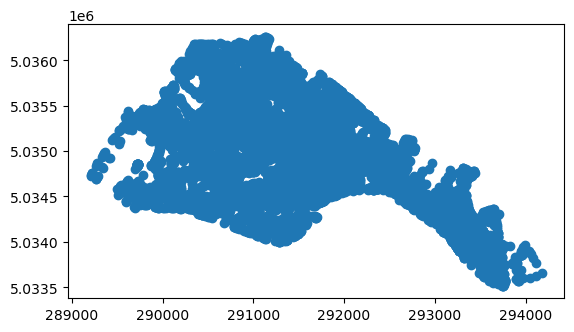

In [36]:
nodes_proj.plot()
plt.show()

In [37]:
lines_proj = ox.graph_to_gdfs(G_proj, nodes=False)

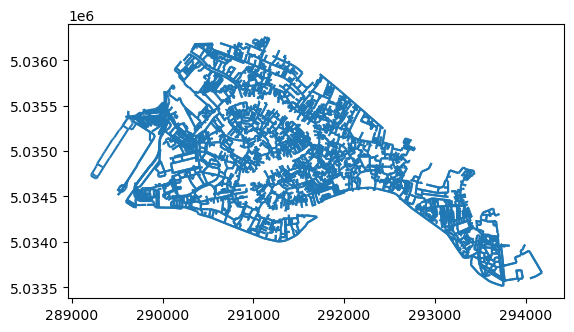

In [38]:
lines_proj.plot()
plt.show()

... and we can use it as a normal geodaframe<br/>

Eg:<br/>
what sized area does our network cover in square meters?

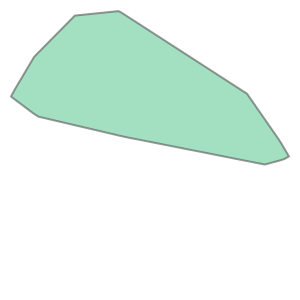

In [39]:
nodes_proj.unary_union.convex_hull

In [40]:
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

7404188.313917128

with OSMnx we can extract some basic statistics 

In [41]:
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 15131,
 'm': 32792,
 'k_avg': 4.334412794924328,
 'edge_length_total': 399398.616,
 'edge_length_avg': 12.179757745791656,
 'streets_per_node_avg': 2.2152534531756,
 'streets_per_node_counts': {0: 0,
  1: 1429,
  2: 9574,
  3: 3611,
  4: 488,
  5: 20,
  6: 6,
  7: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09444187429779922,
  2: 0.632740730949706,
  3: 0.23864913092327011,
  4: 0.03225166875950036,
  5: 0.0013217897032582115,
  6: 0.0003965369109774635,
  7: 0.00019826845548873175},
 'intersection_count': 13702,
 'street_length_total': 203465.976,
 'street_segment_count': 16734,
 'street_length_avg': 12.158836859089279,
 'circuity_avg': 0.9987471004991363,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 323,
 'node_density_km': 2043.5730911326675,
 'intersection_density_km': 1850.5742181415512,
 'edge_density_km': 53942.25525697107,
 'street_density_km': 27479.848887360065,
 'clean_intersection_density_km': 43.623957995892646}

stats documentation: [https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats)

## Glossary of the terms used by the statistics

For a complete list look the [networkx documentation](https://networkx.org/documentation/stable/)

- **density**<br/>defines the density of a graph. The density is 0 for a graph without edges and 1 for a complete graph. The density of multigraphs can be higher than 1.
- **center**<br/>is the set of points with eccentricity equal to radius.
- **betwnees centrality**<br/>is the number of possible interactions between two non-adjacent points
- **closeness centrality**<br/>is the average distance of a point from all the others
- **clustering coefficient**<br/>the measure of the degree to which points in a graph tend to cluster together
- **degree centrality**<br/>the number of lines incident upon a point 
- **eccentricity** <br/>the eccentricity of a point in a graph is defined as the length of a longest shortest path starting at that point
- **diameter**<br/>the maximum eccentricity
- **edge connectivity**<br/>
is equal to the minimum number of edges that must be removed to disconnect a graph or render it trivial.
- **node connectivity**<br/>
is equal to the minimum number of points that must be removed to disconnect a graph or render it trivial.
- **pagerank**<br/>
computes a ranking of the nodes (points) in a graph based on the structure of the incoming links (lines). It was originally designed as an algorithm to rank web pages.
- **periphery** <br/>is the set of nodes with eccentricity equal to the diameter
- **radius**<br/>is the minimum eccentricity.

... and we can plot the map

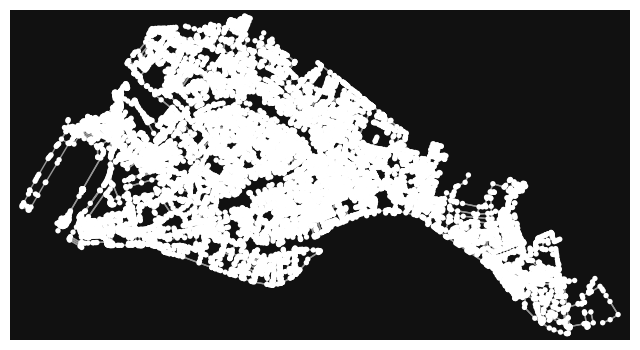

In [42]:
fig, ax = ox.plot_graph(G)
plt.show()

In [43]:
import networkx as nx

In [44]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

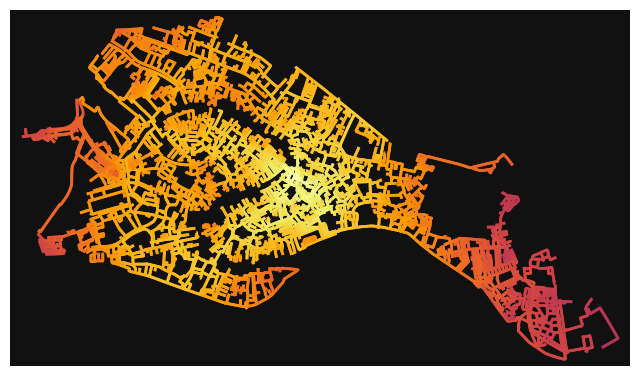

In [ ]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)
plt.show()

# Find the shortest path between 2 points by minimizing travel time


## calculate the travel time for each edge

### define the origin and destination
Example:

from the train station of Venezia Santa Lucia to the Rialto Bridge


**train station**

[Venezia Santa Lucia](https://www.openstreetmap.org/node/6063641885)

lat: 45.4410753<br/>
lon: 12.3210322


**Rialto Bridge**

[Ponte di Rialto](https://www.openstreetmap.org/way/199258374)

lat: 45.43805<br/>
lon: 12.33593





## find the node on the graph nearest on the point given

thes two points are NOT on the graph.

We need to find the nodes nearest

In [ ]:
point_nearest_train_station = ox.distance.nearest_nodes(G,Y=45.4410753,X=12.3210322)
point_nearest_bridge_rialto = ox.distance.nearest_nodes(G,Y=45.43805,X=12.33593)

In [ ]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)


### calculate the time to walk over each edges

In [ ]:
G = ox.graph_from_place(place_name, network_type='walk')

plot the walkable street network

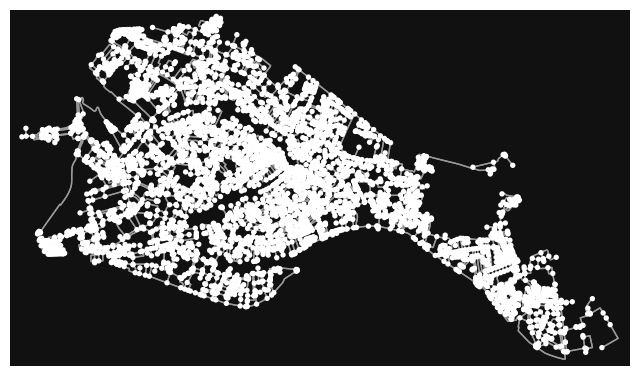

In [ ]:
fig, ax = ox.plot_graph(G)
plt.show()

In [ ]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

... geopandas investigation

In [ ]:
edges = ox.graph_to_gdfs(G,edges=True,nodes=False)

In [ ]:
edges.head(3)

osmid bridge             name  highway  oneway  \
u        v          key                                                       
27178184 764403528  0    166489461    yes  Ponte di Rialto  footway   False   
         1675825096 0    166489461    yes  Ponte di Rialto  footway   False   
         8670969688 0    450089474    yes  Ponte di Rialto    steps   False   

                        reversed  length  speed_kph  travel_time width  \
u        v          key                                                  
27178184 764403528  0      False   9.935       41.0          0.9   NaN   
         1675825096 0       True   5.120       41.0          0.4   NaN   
         8670969688 0      False   9.212       41.0          0.8     7   

                                                                  geometry  \
u        v          key                                                      
27178184 764403528  0    LINESTRING (12.33569 45.43820, 12.33561 45.43813)   
         1675825096 0    LINESTRING (12.33569 45.43820, 12.33573 45.43823)   
         8670969688 0    LINESTRING (12.33569 45.43820, 12.33560 45.43825)   

                        tunnel lanes maxspeed est_width access area service  \
u        v          key                                                       
27178184 764403528  0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   
         1675825096 0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   
         8670969688 0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   

                        junction  
u        v          key           
27178184 764403528  0        NaN  
         1675825096 0        NaN  
         8670969688 0        NaN

In [ ]:
edges.columns

Index(['osmid', 'bridge', 'name', 'highway', 'oneway', 'reversed', 'length',
       'speed_kph', 'travel_time', 'width', 'geometry', 'tunnel', 'lanes',
       'maxspeed', 'est_width', 'access', 'area', 'service', 'junction'],
      dtype='object')

In [ ]:
edges[edges.travel_time == edges.travel_time.max()].name

u            v            key
1927219469   11182286836  0      NaN
11182286836  1927219469   0      NaN
Name: name, dtype: object

In [ ]:
edges[edges.travel_time == edges.travel_time.max()].osmid

u            v            key
1927219469   11182286836  0      [404610512, 404610513]
11182286836  1927219469   0      [404610512, 404610513]
Name: osmid, dtype: object

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/osmid_3400471.jpg)

https://www.openstreetmap.org/way/404610513

## find the shortest path between the train station and Rialto bridge 

In [ ]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, point_nearest_train_station, point_nearest_bridge_rialto, weight="travel_time")

In [ ]:
route

[1927219479,
 3527986497,
 2493856508,
 9055796707,
 1921651801,
 27239442,
 5372700772,
 4899902714,
 1855450146,
 3371984917,
 2514483400,
 1858198295,
 1858198260,
 3371984290,
 3371984894,
 5360645772,
 1855473678,
 1855473687,
 4849873712,
 4849867342,
 1856706712,
 3389313497,
 5149979474,
 2732099927,
 4843929370,
 2732099913,
 2732099919,
 2732099909,
 2732099904,
 4803731379,
 4846061555,
 1857205293,
 1857205281,
 3392463459,
 1857205288,
 1856788519,
 3392463420,
 3392463416,
 1857148234,
 1840378080,
 2249214723,
 4803872602,
 4803871721,
 1857139330,
 4902225461,
 6026202973,
 1857139318,
 1857139273,
 1857139324,
 1857139332,
 4983211717,
 4983211715,
 5649829357,
 282975977,
 4821479726,
 4977488959,
 4982153142,
 4982195156,
 4982195157,
 8670969688,
 27178184,
 5395065019]

these values are the ids of each node of the graph

In [ ]:
G.nodes[5395065019]

{'y': 45.4380532, 'x': 12.3359319, 'street_count': 4}

In [ ]:
nodes = ox.graph_to_gdfs(G,edges=False,nodes=True)

In [ ]:
nodes

,y,x,street_count,highway,geometry
osmid,,,,,
27178184,45.438197,12.335686,4,NaN,POINT (12.33569 45.43820)
27178422,45.432325,12.337206,4,NaN,POINT (12.33721 45.43233)
27178423,45.432482,12.337658,3,NaN,POINT (12.33766 45.43248)
27178433,45.429240,12.327350,3,NaN,POINT (12.32735 45.42924)
27223839,45.434570,12.350321,3,NaN,POINT (12.35032 45.43457)
...,...,...,...,...,...
11090414679,45.434097,12.349435,3,NaN,POINT (12.34943 45.43410)
11090414680,45.434147,12.349193,1,NaN,POINT (12.34919 45.43415)
11182286836,45.442820,12.315304,3,NaN,POINT (12.31530 45.44282)


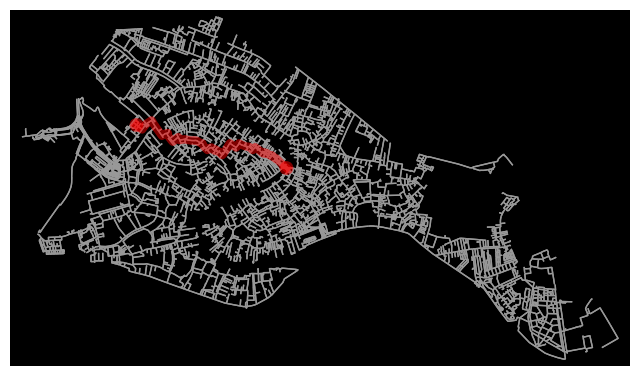

In [ ]:
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')
plt.show()


In [ ]:
ox.plot_route_folium(G,route,popup_attribute='name',tiles='CartoDB dark_matter')
#OpenStreetMap
#Stamen Terrain
#Steman Toner
#Stamen Watercolor
#CartoDB positron
#CartoDB dark_matter

how long is our route in meters?

In [ ]:
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

1613.023

how many minutes does it take?

In [ ]:
import datetime

In [ ]:
edge_times = ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')
seconds = sum(edge_times)

In [ ]:
seconds

141.20000000000007

In [ ]:
str(datetime.timedelta(seconds=seconds))

'0:02:21.200000'

## calculate bearing

Calculate the compass bearing from origin node to destination node for each edge in the directed graph then add each bearing as a new edge attribute. Bearing represents angle in degrees (clockwise) between north and the direction from the origin node to the destination node.
<br/><br/>


In [ ]:
cols = ['city']
names = [('Roma'),('Trento'),('Genova'),('Trieste'),('Venezia')]
cities = gpd.GeoDataFrame(names,columns=cols)
geo_cities = gpd.tools.geocode(cities.city, provider="arcgis")

In [ ]:
cities

,city
0,Roma
1,Trento
2,Genova
3,Trieste
4,Venezia


In [ ]:
geo_cities

,geometry,address
0,POINT (12.49565 41.90322),Roma
1,POINT (11.11929 46.07005),Trento
2,POINT (8.93917 44.41048),Genova
3,POINT (13.77269 45.65757),Trieste
4,POINT (12.31815 45.43811),Venezia


In [ ]:
trento = geo_cities[geo_cities.address == 'Trento'].geometry

In [ ]:
trento.geometry.x.values[0]

11.11929

In [ ]:
roma = geo_cities[geo_cities.address == 'Roma']
genova = geo_cities[geo_cities.address == 'Genova']
trieste = geo_cities[geo_cities.address == 'Trieste']
venezia = geo_cities[geo_cities.address == 'Venezia']

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Compass_Card_B%2BW.svg/480px-Compass_Card_B%2BW.svg.png)

In [ ]:
#Trento - Roma
ox.bearing.calculate_bearing(trento.geometry.y.values[0],trento.geometry.x.values[0],roma.geometry.y.values[0],roma.geometry.x.values[0])

166.14931950629045

In [ ]:
#Trento - Trieste
ox.bearing.calculate_bearing(trento.geometry.y.values[0],trento.geometry.x.values[0],trieste.geometry.y.values[0],trieste.geometry.x.values[0])

101.62965042130071

In [ ]:
#Trento - Venezia
ox.bearing.calculate_bearing(trento.geometry.y.values[0],trento.geometry.x.values[0],venezia.geometry.y.values[0],venezia.geometry.x.values[0])

126.63919232581111

In [ ]:
#Trento - Genova
ox.bearing.calculate_bearing(trento.geometry.y.values[0],trento.geometry.x.values[0],genova.geometry.y.values[0],genova.geometry.x.values[0])

223.54736298562918

## Calculate isochornes

In [ ]:
trip_times = [3, 6, 9, 15]  # in minutes
travel_speed = 4  # walking speed in km/hour
from shapely.geometry import Point

In [ ]:
# we select the train station as center
center_node = point_nearest_train_station
center_node = point_nearest_bridge_rialto

In [ ]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for orig,dest, p, data in G_proj.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [ ]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G_proj, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)



In [ ]:
crs_proj = ox.graph_to_gdfs(G_proj)[0].crs

In [ ]:
data = {'trip_time': sorted(trip_times, reverse=True), 'geometry': isochrone_polys}
isochrones = gpd.GeoDataFrame(data,crs=crs_proj)

In [ ]:
isochrones.explore(column='trip_time',cmap='Reds')

---

# Use GraphHoper

![](https://www.graphhopper.com/wp-content/uploads/2018/03/graphhopper-logo-small.png)

Visit [https://www.graphhopper.com/](https://www.graphhopper.com/)

## Install a local instance
- download data from OpenStreetMap<br/>Example: L'Aquila<br/><br/>[https://osmit-estratti.wmcloud.org/output/pbf/comuni/066049_L'Aquila.osm.pbf]
java 17.0.1 2021-10-19 LTS
Java(TM) SE Runtime Environment (build 17.0.1+12-LTS-39)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.1+12-LTS-39, mixed mode, sharing)
</pre>
- download the jar of grapphoper from github - [https://repo1.maven.org/maven2/com/graphhopper/graphhopper-web/7.0/graphhopper-web-7.0.jar](https://repo1.maven.org/maven2/com/graphhopper/graphhopper-web/7.0/graphhopper-web-7.0.jar)
- create the yaml file configuration for the graphhopper with the variabile <pre>datareader.file</pre> equals to the file name you donwloaded (eg."022205_Trento.osm.pbf") and the configuration with the different profiles (eg. car, bike, foot ...).<br/>An example [here](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/data/conf_grapphoper/config_trento.yml)
- run the grapphoper istance<br/><pre>java -jar graphhopper*.jar server config_laquila.yml</pre>
- you can reach the service at <pre>http://localhost:8989</pre> 

Here a bash script to download everything<br/>
tip: create a working directory

```bash
wget "https://osmit-estratti.wmcloud.org/output/pbf/comuni/066049_L'Aquila.osm.pbf" -O laquila.pbf
wget https://repo1.maven.org/maven2/com/graphhopper/graphhopper-web/7.0/graphhopper-web-7.0.jar
wget https://raw.githubusercontent.com/napo/geospatialdataanalysis_gssi/main/data/config_laquila.yml
```


later run the service and ... have patience for the first run because graphhopper needs to parse the pbf file gave in input


```bash
java -jar graphhopper*.jar server config_laquila.yml
```

You can use the bash script [here](https://raw.githubusercontent.com/napo/geospatialdataanalysis_gssi/main/data/graphhopper_start.sh)

The base URL now is: <pre>http://localhost:8989</pre> 

Otherwise you can use the official instance with a token api and relative [prices](https://www.graphhopper.com/pricing/)

Here a list of the more important API available

| end point | function | description |
|---|---|---|
|http://localhost:8989/| maps | web client front-end for routing |
|http://localhost:8989/health| health | inform if the service is running |
|http://localhost:8989/isochrone| isochrone | calculate the isochrone [here](https://docs.graphhopper.com/#tag/Isochrone-API) the documentation |
|http://localhost:8989/match| match | map matching service in POST - [here](https://docs.graphhopper.com/#tag/Map-Matching-API) the documentation |
|http://localhost:8989/route| routing service | documentation [here](https://docs.graphhopper.com/#tag/Routing-API)|


## How to use it
### routing

Calculate the routing from [Sanbapolis](https://www.openstreetmap.org/?mlat=46.04717&mlon=11.13261#map=18/46.04717/11.13261) to [BUC](https://www.openstreetmap.org/?mlat=46.05968&mlon=11.11552#map=19/46.05968/11.11552)

Sanbapolis: 
- latitude: 46.04717
- longitude: 11.13261

BUC:
- latitude: 46.05968
- longitude: 11.11552

Syntax in GET:
```
http://localhost:8989/route?point=latitude,longitude&point=latitude,longitude
```

In [ ]:
import requests

url = "http://localhost:8989/route"
start_latitude = "46.04717"
start_longitude = "11.13261"
start_point = start_latitude + "," + start_longitude
end_latitude = "46.05968"
end_longitude = "11.11552"
end_point = end_latitude + "," + end_longitude

query = "?profile=car"
query += "&locale=it"
query += "&point=" +start_point
query += "&point=" +end_point

response = requests.get(url+query) 

data = response.json()
print(data.keys())

dict_keys(['hints', 'info', 'paths'])


In [ ]:
data['hints']

{'visited_nodes.sum': 54, 'visited_nodes.average': 54.0}

In [ ]:
data['info']

{'copyrights': ['GraphHopper', 'OpenStreetMap contributors'], 'took': 24}

In [ ]:
len(data['paths'])

1

In [ ]:
data['paths'][0].keys()

dict_keys(['distance', 'weight', 'time', 'transfers', 'points_encoded', 'bbox', 'points', 'instructions', 'legs', 'details', 'ascend', 'descend', 'snapped_waypoints'])

In [ ]:
data['paths'][0]['distance'] #meters

2898.391

In [ ]:
data['paths'][0]['time'] #milliseconds

270285

In [ ]:
data['paths'][0]['points'] 

'wq`xGyi}bAFF\\FhHIPJDVFpEQ^qA@cBTSHuQm@u@Hi@`@OOK?MJER@JM@qDtBa@RqAb@iAZ{AN}EBkEt@c@NcAj@qSnIqBbC}BdCeGhGr@pFfD`Z?RERMBGP?NBL?bDHpBP`CJlD`@F'

We need the polyne encoder/decoder

Check here the [documentation](https://developers.google.com/maps/documentation/utilities/polylinealgorithm)

In [ ]:
try:
    import polyline 
except ModuleNotFoundError as e:
    !pip install -U polyline==2.0.1 --break-system-packages
    import polyline

In [ ]:
points = polyline.decode(data['paths'][0]['points'] )

In [ ]:
from shapely.geometry import LineString
from shapely.ops import transform
route = LineString(points)

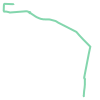

In [ ]:
route

In [ ]:
route = transform(lambda x, y: (y, x),route)

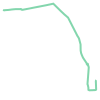

In [ ]:
route

In [ ]:
routing_result = gpd.GeoDataFrame(
    [{"time": data['paths'][0]['time'],"geometry": route, "distance":data['paths'][0]['distance']}],
    crs="epsg:4326",
    geometry="geometry")

In [ ]:
routing_result.explore()

#### and by foot

In [ ]:
query = "?profile=foot"
query += "&locale=it"
query += "&point=" +start_point
query += "&point=" +end_point
query += "&ch.disable=true" 
response = requests.get(url+query) 
data = response.json()
points = polyline.decode(data['paths'][0]['points'])
route = transform(lambda x, y: (y, x),LineString(points))
routing_result = gpd.GeoDataFrame(
    [{"time": data['paths'][0]['time'],"geometry": route, "distance":data['paths'][0]['distance']}],
    crs="epsg:4326",
    geometry="geometry")
routing_result.explore()

### ischrone

Calculate a isochrone of 5 minutes of [Sanbapolis](https://www.openstreetmap.org/?mlat=46.04717&mlon=11.13261#map=18/46.04717/11.13261) 

Sanbapolis: 
- latitude: 46.04717
- longitude: 11.13261
Syntax in GET:
```
http://localhost:8989/isochrone?point=latitude,longitude&time_limit=timeseconds&distance_limit=distance&profile=foot&bucket=1&reverse_flow=false
```

In [ ]:
url = "http://localhost:8989/isochrone"
lat = "46.04717"
lon = "11.13261"
minutes_distance = 5
timeseconds = str(minutes_distance*60)
p = lon + "," + lat
query = {
  "point": lat + "," + lon,
  "time_limit": timeseconds,
  "distance_limit": "0",
  "profile": "foot",
  "buckets": "1",
  "reverse_flow": "false"}
response = requests.get(url, params=query)
data = response.json()

In [ ]:
from shapely.geometry import Polygon
geometry = Polygon(data['polygons'][0]['geometry']['coordinates'][0])

In [ ]:
isochrone = gpd.GeoDataFrame(
    [{"minutes_distance":minutes_distance,"geometry": geometry}],
    crs="epsg:4326",
    geometry="geometry")

In [ ]:
isochrone.explore()

### Istodistance
... and in 300 meters

In [ ]:
distance = 300
p = lon + "," + lat
query = {
  "point": lat + "," + lon,
  "time_limit": 0,
  "distance_limit":distance,
  "profile": "foot",
  "buckets": "1",
  "reverse_flow": "false"}
response = requests.get(url, params=query)
data = response.json()

In [ ]:
geometry = Polygon(data['polygons'][0]['geometry']['coordinates'][0])
isodistance = gpd.GeoDataFrame(
    [{"minutes_distance":minutes_distance,"geometry": geometry}],
    crs="epsg:4326",
    geometry="geometry")
isodistance.explore()

## Map Matching

![](https://fmm-wiki.github.io/assets/images/demo2.gif)

Read the documentation of [Fast Map Matching](https://fmm-wiki.github.io/)




An example 

![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/journey_trento_downtown.png)

[Download](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/data/journey_trento_downtown.gpx)

http://localhost:8989/maps/map-matching/

In [ ]:
import requests
headers = {
    'content-type': 'application/gpx+xml',
}
gpx_url = "https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/data/journey_trento_downtown.gpx"
response = requests.get(gpx_url)
gpx_str = response.content
url = 'http://localhost:8989/match'
params = {
    'profile': 'foot',
    'gps_accuracy': '10',
    'type': 'json'
}
response = requests.post(url, headers=headers, params=params, data=gpx_str,verify=False)
data = response.json()

In [ ]:
data.keys()

dict_keys(['hints', 'info', 'paths', 'map_matching'])

In [ ]:
data['map_matching']

{'original_distance': 1342.374625154211,
 'distance': 1370.7233911462508,
 'time': 986924}

In [ ]:
len(data['paths'])

1

In [ ]:
data['paths'][0].keys()

dict_keys(['distance', 'weight', 'time', 'transfers', 'points_encoded', 'bbox', 'points', 'instructions', 'legs', 'details', 'ascend', 'descend', 'snapped_waypoints'])

In [ ]:
points = polyline.decode(data['paths'][0]['points'] )

In [ ]:
route = LineString(points)
route = transform(lambda x, y: (y, x),route)
routing_result = gpd.GeoDataFrame(
    [{"time": data['paths'][0]['time'],"geometry": route, "distance":data['paths'][0]['distance']}],
    crs="epsg:4326",
    geometry="geometry")
routing_result.explore()

---

# GNSS
 
 Global Navigation Satellite System (GNSS) refers to a constellation of satellites providing signals from space that transmit positioning and timing data to GNSS receivers. The receivers then use this data to determine location. By definition, GNSS provides global coverage.

## basic
![](https://ardupilot.org/copter/_images/ag_GPS_Operation_New_low_res.jpg)

## with corrections
![](https://freesvg.org/img/GPS_differentialCorrection.png)

---


# GPX Format
GPX, or GPS Exchange Format, is an XML schema designed as a common GPS data format for software applications. It can be used to describe waypoints, tracks, and routes.

## units
### position
latitude and longitude are expressed in **decimal degrees**, and **elevation in meters**, both using the **WGS 84 datum** (epsg 4326).
### time
dates and times are not local time, but instead are Coordinated Universal Time (UTC) using ISO 8601 format (YYYY-MM-DDTHH:MM:SSZ)


## data 

![](https://upload.wikimedia.org/wikipedia/commons/a/a2/Wayroutrackp.png)

(image by [Berklas](https://commons.wikimedia.org/w/index.php?title=User:Berklas) distributed under cc-by-sa 3.0)

- **wptType** is an individual waypoint among a collection of points with no sequential relationship. It consists of the WGS 84 (GPS) coordinates of a point and possibly other descriptive information.
- **rteType** is a route, an ordered list of routepoint (waypoints representing a series of significant turn or stage points) leading to a destination.
- **trkType** is a track, made of at least one segment containing waypoints, that is, an ordered list of points describing a path. A Track Segment holds a list of Track Points which are logically connected in order. To represent a single GPS track where GPS reception was lost, or the GPS receiver was turned off, start a new Track Segment for each continuous span of track data.


details about the format on fhe officiale [website](https://www.topografix.com/gpx.asp)


```xml
<?xml version="1.0" encoding="UTF-8" standalone="no" ?>
<gpx xmlns="http://www.topografix.com/GPX/1/1" xmlns:gpxx="http://www.garmin.com/xmlschemas/GpxExtensions/v3" xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v1" creator="Oregon 400t" version="1.1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd http://www.garmin.com/xmlschemas/GpxExtensions/v3 http://www.garmin.com/xmlschemas/GpxExtensionsv3.xsd http://www.garmin.com/xmlschemas/TrackPointExtension/v1 http://www.garmin.com/xmlschemas/TrackPointExtensionv1.xsd">
  <metadata>
    <link href="http://www.garmin.com">
      <text>Garmin International</text>
    </link>
    <time>2009-10-17T22:58:43Z</time>
  </metadata>
  <trk>
    <name>Example GPX Document</name>
    <trkseg>
      <trkpt lat="47.644548" lon="-122.326897">
        <ele>4.46</ele>
        <time>2009-10-17T18:37:26Z</time>
      </trkpt>
      <trkpt lat="47.644548" lon="-122.326897">
        <ele>4.94</ele>
        <time>2009-10-17T18:37:31Z</time>
      </trkpt>
      <trkpt lat="47.644548" lon="-122.326897">
        <ele>6.87</ele>
        <time>2009-10-17T18:37:34Z</time>
      </trkpt>
    </trkseg>
  </trk>
</gpx>
```

information from [wikipedia](https://en.wikipedia.org/wiki/GPS_Exchange_Format)

---

# Commmon problems 

Missing Data
- Temporal gaps
- Spatial gaps

Incorrect data:
- location or time is incorrect in the data frame

Outliers:
- Too fast movements
- Incorrect order of temporal information 


## A funny story 

Channon Perry and her boyfriend [analysed](https://chan.co.za/how-fateful) their personal GPS traces to find ‘missed potential fateful encounters’ in the past.


---

## Playing with GPX

In [ ]:
try:
  import gpxpy
except ModuleNotFoundError as e:
  !pip install gpxpy==1.5.0
  import gpxpy

if gpxpy.__version__ != "1.5.0":
  !pip install -U gpxpy==1.5.0

In [ ]:
import gpxpy
import urllib.request
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore') # ignore warnings

In [ ]:
try:
  import hvplot 
except ModuleNotFoundError as e:
  !pip install hvplot==0.8.4
  import hvplot

if hvplot.__version__ != "0.8.4":
  !pip install -U hvplot==0.8.4

try:
  import geoviews 
except ModuleNotFoundError as e:
  !pip install geoviews==1.10.1
  import geoviews

if geoviews.__version__ != "1.10.1":
  !pip install -U geoviews==1.10.1
  

In [ ]:
try:
  import movingpandas as mpd
except ModuleNotFoundError as e:
  !pip install movingpandas==0.17.1
  import movingpandas as mpd

if mpd.__version__ != "0.17.1":
  !pip install -U movingpandas==0.17.11

## Download the data


![](https://github.com/napo/geospatial_course_unitn/blob/master/images/strava_clean.jpg?raw=true)

If you are registered and the author permits the download you can download the gps track but and investigate with [GPX Studio](https://gpx.studio) **without timestamps**


![gpx-strava.png](https://i.postimg.cc/x8mMQL9C/gpx-strava.png)] 

[download file](https://gist.github.com/napo/2aa15957b687dd676d448888619bd39f)

or ... you can use [Strava To Gpx](https://mapstogpx.com/strava/) 


![gpx-full.png](https://i.postimg.cc/yNrLYXCX/gpx-full.png)]

[download file](https://gist.github.com/napo/4d0c14585da0ef96f263faa0e8d97ff5)


In [ ]:
gpx_url = "https://gist.githubusercontent.com/napo/4d0c14585da0ef96f263faa0e8d97ff5/raw/efba18f806459b462a1e485023cdd01c4d20e01a/strava_full.gpx"
gpx_file = "strava_full.gpx"
urllib.request.urlretrieve(gpx_url,gpx_file)
gpx_file = open(gpx_file, 'r')
gpx = gpxpy.parse(gpx_file)

In [ ]:
gpx.creator

'https://www.mapstogpx.com/strava'

In [ ]:
len(gpx.tracks)

1

In [ ]:
len(gpx.tracks[0].segments)

1

In [ ]:
segment = gpx.tracks[0].segments[0]

In [ ]:
segment

GPXTrackSegment(points=[...])

In [ ]:
type(segment.points)

list

In [ ]:
segment.points[0].latitude

45.900222

In [ ]:
segment.points[0].longitude

10.847826

In [ ]:
segment.points[0].elevation

96.5

## creation of a pandas DataFrame

In [ ]:
import movingpandas as mpd
import pandas as pd
data = []
for point_idx, point in enumerate(segment.points):
    data.append([point.longitude, point.latitude,
                point.elevation, point.time]) 

columns = ['longitude', 'latitude', 'altitude', 'time'] 
gpx_tracks = pd.DataFrame(data, columns=columns)
# Strava to GPX assign the date of the download of the file as timestamp and SimpleTZ("Z") as TimeZone.
# we can remove it
gpx_tracks['time'] = gpx_tracks['time'].apply(lambda x: x.replace(tzinfo=None))

# index creation needed by MovingPandas
df = gpx_tracks.set_index('time')

In [ ]:
start_point = data[0]
end_point = data[-1]
# travel time
# steps to calcolate the difference of time from the timestamp in the first point to the last.
travel_time = end_point[3]-start_point[3]
travel_time_seconds = timedelta(seconds=travel_time.total_seconds())
travel_time_hours = str(timedelta(seconds=travel_time_seconds.seconds))
print_travel_time = travel_time_hours.split(':')
print("travel time %sh %s' %s''" % (print_travel_time[0], print_travel_time[1], print_travel_time[2]))

travel time 2h 34' 41''


## reverse geocoding

In [ ]:
from geopy.geocoders import Nominatim 

latlon = str(start_point[1]) + "," + str(start_point[0])
geolocator = Nominatim(user_agent="geospatial course unitn")
starting_place = geolocator.reverse(latlon)

In [ ]:
starting_place

Location(28/C, Via Luigi Pigarelli, Pasina, Varone, Riva del Garda, Comunità Alto Garda e Ledro, Provincia di Trento, Trentino-Alto Adige/Südtirol, 38066, Italia, (45.8999431, 10.8472436, 0.0))

In [ ]:
latlon = str(end_point[1]) + "," + str(end_point[0])
geolocator = Nominatim(user_agent="geospatial course unitn")
arrival_place = geolocator.reverse(latlon)

In [ ]:
arrival_place

Location(Ospedale di Arco, 48, Viale dei Capitelli, Chiarano, Arco, Comunità Alto Garda e Ledro, Provincia di Trento, Trentino-Alto Adige/Südtirol, 38062, Italia, (45.919666250000006, 10.875398703679842, 0.0))

##  Analyzing trajectories


In [ ]:
# GeoDataFrame for MovingPandas
geo_df = gpd.GeoDataFrame(df, 
crs=4326,
geometry= gpd.points_from_xy(df.longitude, df.latitude, df.altitude))

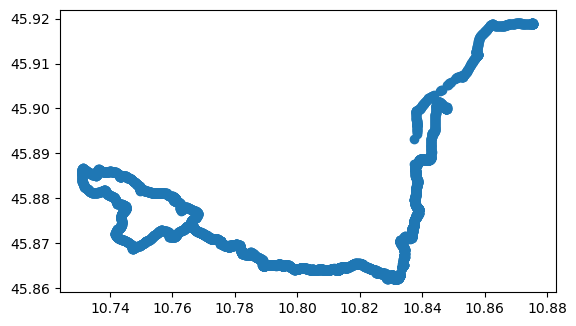

In [ ]:
geo_df.plot()
plt.show()

In [ ]:
trajectory = mpd.Trajectory(geo_df, 0)

In [ ]:
trajectory

Trajectory 0 (2021-10-12 12:01:38 to 2021-10-12 14:36:19) | Size: 5532 | Length: 40316.6m
Bounds: (10.731099, 45.861882, 10.875513, 45.919142)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836

In [ ]:
# object trajectory from MovingPandas
trajectory = mpd.Trajectory(geo_df, 1)

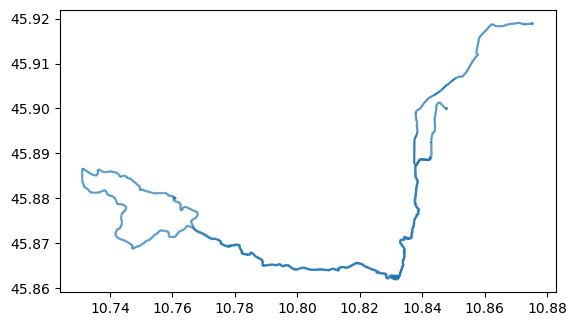

In [ ]:
trajectory.plot()
plt.show()

In [ ]:
trajectory.add_speed(overwrite=True)
trajectory.df

,longitude,latitude,altitude,geometry,traj_id,speed
time,,,,,,
2021-10-12 12:01:38,10.847826,45.900222,96.5,POINT Z (10.84783 45.90022 96.50000),1,5.026084
2021-10-12 12:01:39,10.847850,45.900264,96.5,POINT Z (10.84785 45.90026 96.50000),1,5.026084
2021-10-12 12:01:40,10.847843,45.900125,96.5,POINT Z (10.84784 45.90013 96.50000),1,15.459309
2021-10-12 12:01:41,10.847836,45.899890,96.5,POINT Z (10.84784 45.89989 96.50000),1,26.125749
2021-10-12 12:01:42,10.847835,45.899786,96.5,POINT Z (10.84783 45.89979 96.50000),1,11.559794
...,...,...,...,...,...,...
2021-10-12 14:34:13,10.875184,45.919097,91.6,POINT Z (10.87518 45.91910 91.60000),1,0.765202
2021-10-12 14:34:20,10.875213,45.919122,91.6,POINT Z (10.87521 45.91912 91.60000),1,0.510754
2021-10-12 14:34:30,10.875186,45.919142,91.6,POINT Z (10.87519 45.91914 91.60000),1,0.305432


In [ ]:
# conversion m/s to km/h
def ms_to_km(ms):
    v = (ms) * (60*60)/1000
    return v

In [ ]:
# km/h column
trajectory.df['kmh'] = trajectory.df['speed'].apply(ms_to_km)

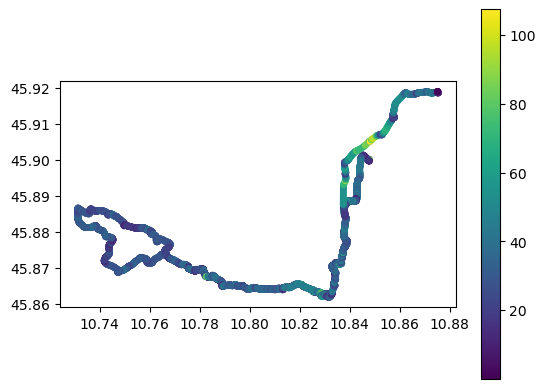

In [ ]:
trajectory.plot(column="kmh", linewidth=5, capstyle='round', legend=True)
plt.show()

## Extracting a moving object's position was at a certain time 

In [ ]:
trajectory

Trajectory 1 (2021-10-12 12:01:38 to 2021-10-12 14:36:19) | Size: 5532 | Length: 40316.6m
Bounds: (10.731099, 45.861882, 10.875513, 45.919142)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836

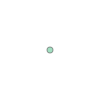

In [ ]:
trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="nearest")

In [ ]:
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="nearest"))

POINT Z (10.840998 45.888594 81.1)


In [ ]:
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="nearest"))
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="interpolated"))
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="ffill")) # from the previous row
print(trajectory.get_position_at(datetime(2021,10,12,12,6,0), method="bfill")) # from the following row

POINT Z (10.840998 45.888594 81.1)
POINT Z (10.840998 45.888594 81.1)
POINT Z (10.840998 45.888594 81.1)
POINT Z (10.840998 45.888594 81.1)


## Extracting trajectory segments based on time

In [ ]:
segment_clip = trajectory.get_segment_between(datetime(2021,10,12,13,36,1),datetime(2021,10,12,13,38,51))
print(segment_clip)

Trajectory 1_2021-10-12 13:36:01 (2021-10-12 13:36:01 to 2021-10-12 13:38:49) | Size: 158 | Length: 1457.3m
Bounds: (10.832986, 45.870462, 10.839058, 45.879066)
LINESTRING Z (10.832986 45.870462 160.3, 10.833045 45.870534 159.9, 10.83311 45.870598 159.5, 10.833


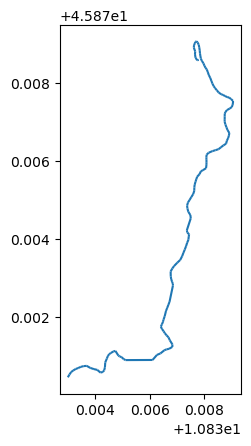

In [ ]:
segment_clip.plot()
plt.show()

## Extracting trajectory segments based on  geometry (i.e. clipping)

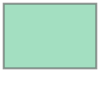

In [ ]:
from shapely.geometry import Point, Polygon
latitude=45.88880
longitude=10.84269
p = Point(longitude, latitude)
point = gpd.GeoDataFrame(pd.DataFrame(), 
    crs=4326,
    geometry= [p])
distance = 10 # meters
# create a bounding box
xmin, ymax, xmax, ymin = point.to_crs(epsg=32632).buffer(distance).geometry.to_crs(epsg=4326).iloc[0].bounds
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
polygon


In [ ]:
intersections = trajectory.clip(polygon)
intersections

TrajectoryCollection with 3 trajectories

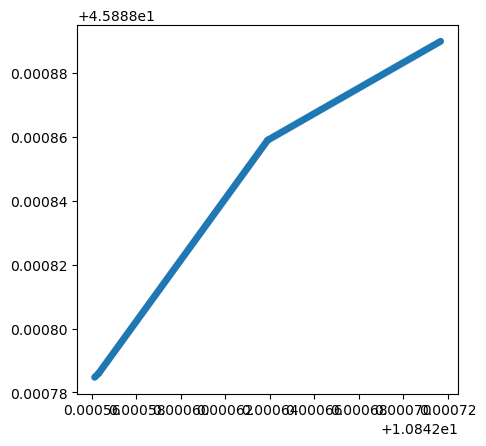

In [ ]:
intersections.trajectories[0].plot(linewidth=5, capstyle='round')
plt.show()

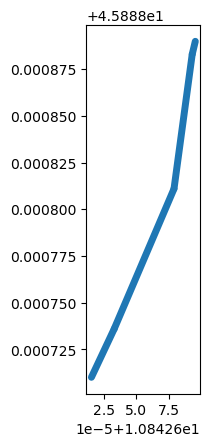

In [ ]:
intersections.trajectories[1].plot(linewidth=5, capstyle='round')
plt.show()

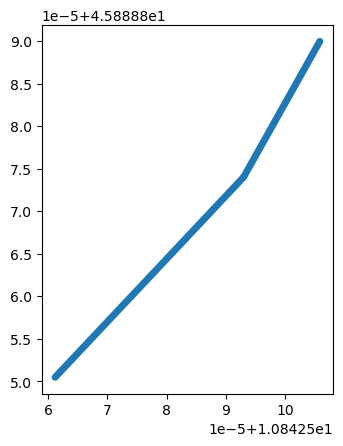

In [ ]:
intersections.trajectories[2].plot(linewidth=5, capstyle='round')
plt.show()

## Splitting trajectories 

Gaps are quite common in trajectories. For example, GPS tracks may contain gaps if moving objects enter tunnels where GPS reception is lost. In other use cases, moving objects may leave the observation area for longer time before returning and continuing their recorded track.

Depending on the use case, we therefore might want to split trajectories at observation gaps that exceed a certain minimum duration:

### duration 15 minutes

In [ ]:
split = mpd.ObservationGapSplitter(trajectory).split(gap=timedelta(minutes=15))
for traj in split:
    print(traj)

Trajectory 1_0 (2021-10-12 12:01:38 to 2021-10-12 13:47:11) | Size: 5070 | Length: 34131.1m
Bounds: (10.731099, 45.861882, 10.84785, 45.901398)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836
Trajectory 1_2 (2021-10-12 14:24:10 to 2021-10-12 14:36:19) | Size: 461 | Length: 6182.5m
Bounds: (10.837456, 45.887391, 10.875513, 45.919142)
LINESTRING Z (10.842638 45.888938 79.4, 10.842624 45.888947 79.5, 10.842587 45.888957 79.5, 10.84259


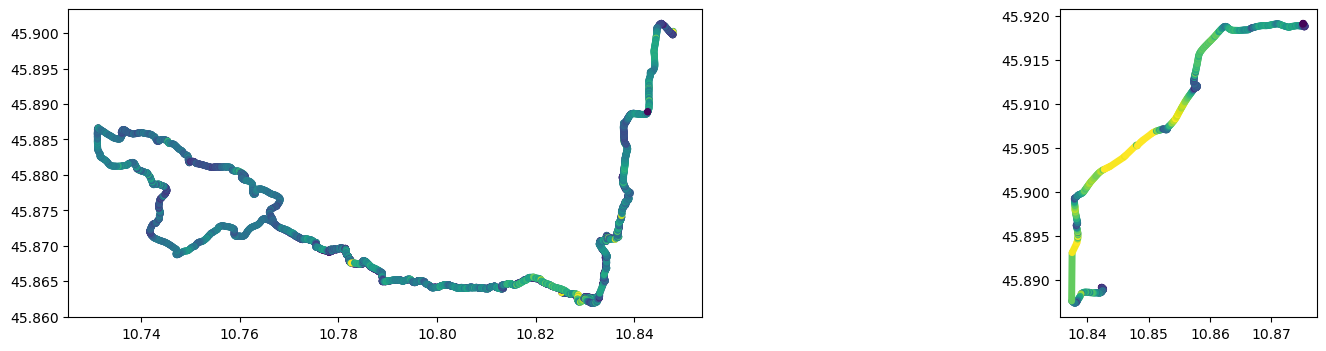

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(19,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)

1Km

In [ ]:
split = mpd.StopSplitter(trajectory).split(min_duration=timedelta(minutes=15), max_diameter=30, min_length=1000)
for traj in split:
    print(traj)

Trajectory 1_2021-10-12 12:01:38 (2021-10-12 12:01:38 to 2021-10-12 13:47:11) | Size: 5070 | Length: 34131.1m
Bounds: (10.731099, 45.861882, 10.84785, 45.901398)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836
Trajectory 1_2021-10-12 14:24:46 (2021-10-12 14:24:46 to 2021-10-12 14:36:19) | Size: 451 | Length: 6139.6m
Bounds: (10.837456, 45.887391, 10.875513, 45.919142)
LINESTRING Z (10.842474 45.889122 80.8, 10.842465 45.88916 80.9, 10.842435 45.889193 81.1, 10.842394


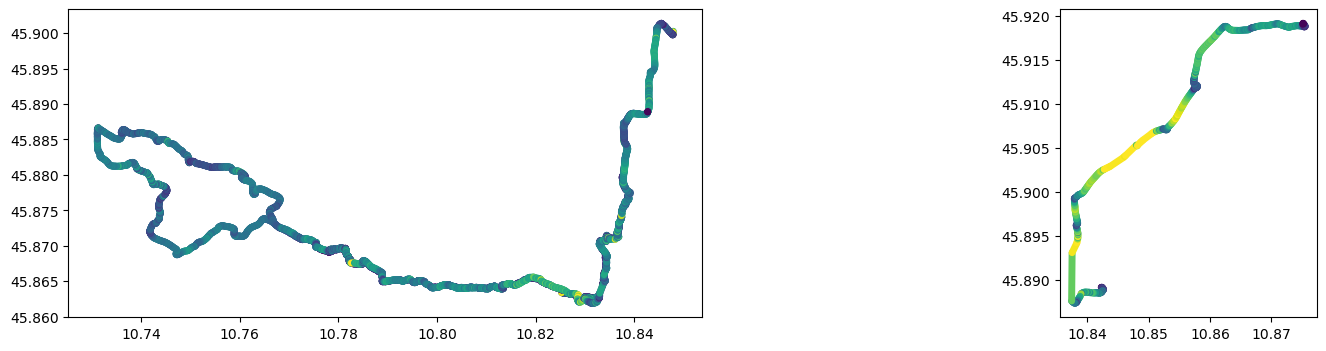

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(19,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)

## Stop detection

In [ ]:
detector = mpd.TrajectoryStopDetector(trajectory)
%time

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


### stop duration

In [ ]:
stop_durations = detector.get_stop_time_ranges(min_duration=timedelta(seconds=60), max_diameter=100)
%%time

UsageError: Line magic function `%%time` not found.


In [ ]:
for x in stop_durations: 
    print(x)

Traj 1: 2021-10-12 12:31:48 - 2021-10-12 12:32:48 (duration: 0 days 00:01:00)
Traj 1: 2021-10-12 12:45:36 - 2021-10-12 12:46:40 (duration: 0 days 00:01:04)
Traj 1: 2021-10-12 12:46:49 - 2021-10-12 12:47:49 (duration: 0 days 00:01:00)
Traj 1: 2021-10-12 12:47:51 - 2021-10-12 12:49:08 (duration: 0 days 00:01:17)
Traj 1: 2021-10-12 12:50:03 - 2021-10-12 12:51:06 (duration: 0 days 00:01:03)
Traj 1: 2021-10-12 12:51:09 - 2021-10-12 12:52:45 (duration: 0 days 00:01:36)
Traj 1: 2021-10-12 13:41:59 - 2021-10-12 14:25:54 (duration: 0 days 00:43:55)
Traj 1: 2021-10-12 14:34:30 - 2021-10-12 14:36:19 (duration: 0 days 00:01:49)


## stop points

In [ ]:
%%time
stop_points = detector.get_stop_points(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 1.61 s, sys: 1 µs, total: 1.61 s
Wall time: 1.62 s


In [ ]:
stop_points

,geometry,start_time,end_time,traj_id,duration_s
stop_id,,,,,
1_2021-10-12 12:31:48,POINT (10.81310 45.86407),2021-10-12 12:31:48,2021-10-12 12:32:48,1,60.0
1_2021-10-12 12:45:36,POINT (10.78240 45.86788),2021-10-12 12:45:36,2021-10-12 12:46:40,1,64.0
1_2021-10-12 12:46:49,POINT (10.78177 45.86865),2021-10-12 12:46:49,2021-10-12 12:47:49,1,60.0
1_2021-10-12 12:47:51,POINT (10.78148 45.86949),2021-10-12 12:47:51,2021-10-12 12:49:08,1,77.0
1_2021-10-12 12:50:03,POINT (10.77875 45.86941),2021-10-12 12:50:03,2021-10-12 12:51:06,1,63.0
1_2021-10-12 12:51:09,POINT (10.77797 45.86928),2021-10-12 12:51:09,2021-10-12 12:52:45,1,96.0
1_2021-10-12 13:41:59,POINT (10.84250 45.88896),2021-10-12 13:41:59,2021-10-12 14:25:54,1,2635.0
1_2021-10-12 14:34:30,POINT (10.87515 45.91913),2021-10-12 14:34:30,2021-10-12 14:36:19,1,109.0


## stop segments

In [ ]:
%%time
stops = detector.get_stop_segments(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.48 s


In [ ]:
stops

TrajectoryCollection with 8 trajectories

## split a stop

In [ ]:
%%time
split = mpd.StopSplitter(trajectory).split(min_duration=timedelta(seconds=60), max_diameter=100)

CPU times: user 1.86 s, sys: 41 µs, total: 1.86 s
Wall time: 1.86 s


In [ ]:
split

TrajectoryCollection with 8 trajectories

In [ ]:
for segment in split:
    print(segment)

Trajectory 1_2021-10-12 12:01:38 (2021-10-12 12:01:38 to 2021-10-12 12:31:48) | Size: 1393 | Length: 8328.3m
Bounds: (10.813493, 45.861981, 10.84785, 45.901398)
LINESTRING Z (10.847826 45.900222 96.5, 10.84785 45.900264 96.5, 10.847843 45.900125 96.5, 10.847836
Trajectory 1_2021-10-12 12:32:48 (2021-10-12 12:32:48 to 2021-10-12 12:45:36) | Size: 620 | Length: 2836.8m
Bounds: (10.782862, 45.863908, 10.812408, 45.867858)
LINESTRING Z (10.812408 45.864088 383.4, 10.812352 45.864073 383.8, 10.812289 45.864066 384.1, 10.81
Trajectory 1_2021-10-12 12:46:40 (2021-10-12 12:46:40 to 2021-10-12 12:46:49) | Size: 5 | Length: 17.1m
Bounds: (10.782128, 45.868145, 10.782239, 45.868274)
LINESTRING Z (10.782239 45.868145 533, 10.782199 45.868181 533.4, 10.782169 45.868201 533.7, 10.7821
Trajectory 1_2021-10-12 12:47:49 (2021-10-12 12:47:49 to 2021-10-12 12:47:51) | Size: 2 | Length: 3.1m
Bounds: (10.781568, 45.869024, 10.781579, 45.869051)
LINESTRING Z (10.781568 45.869024 548.5, 10.781579 45.869051 5

## Generalizing trajectories 

### Douglas-Peucker algorithm

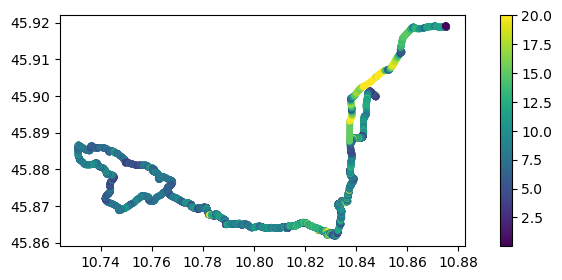

In [ ]:
trajectory.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True, vmax=20)
plt.show()

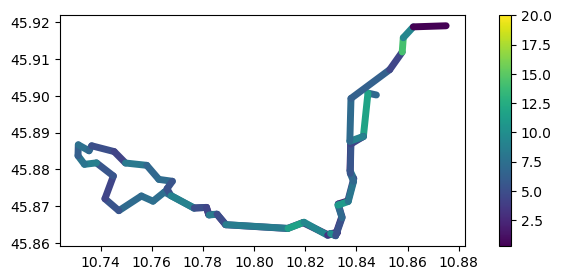

In [ ]:
generalized_trajectory = mpd.DouglasPeuckerGeneralizer(trajectory).generalize(tolerance=0.001)
generalized_trajectory.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True, vmax=20)
plt.show()

In [ ]:
print('Original length: %s'%(trajectory.get_length()))
print('Generalized length: %s'%(generalized_trajectory.get_length()))

Original length: 40316.62984538985
Generalized length: 34969.98458540832


###  alternative down-sample the trajectory to ensure a certain time delta between records

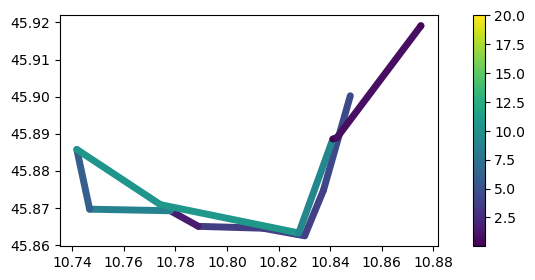

In [ ]:
time_generalized = mpd.MinTimeDeltaGeneralizer(trajectory).generalize(tolerance=timedelta(minutes=10))
time_generalized.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True, vmax=20)
plt.show()

In [ ]:
time_generalized.to_point_gdf().head(10)

,longitude,latitude,altitude,geometry,traj_id,speed,kmh
time,,,,,,,
2021-10-12 12:01:38,10.847826,45.900222,96.5,POINT Z (10.84783 45.90022 96.50000),1,5.026084,18.093904
2021-10-12 12:11:38,10.837393,45.874687,118.6,POINT Z (10.83739 45.87469 118.60000),1,4.446633,16.007878
2021-10-12 12:21:38,10.830129,45.862466,244.0,POINT Z (10.83013 45.86247 244.00000),1,3.863094,13.907137
2021-10-12 12:31:38,10.813936,45.864505,371.3,POINT Z (10.81394 45.86451 371.30000),1,3.815148,13.734534
2021-10-12 12:41:38,10.788925,45.865013,477.9,POINT Z (10.78893 45.86501 477.90000),1,3.525257,12.690925
2021-10-12 12:51:39,10.778118,45.869216,598.4,POINT Z (10.77812 45.86922 598.40000),1,1.619121,5.828837
2021-10-12 13:01:39,10.746818,45.869637,657.8,POINT Z (10.74682 45.86964 657.80000),1,8.849716,31.858976
2021-10-12 13:11:39,10.741853,45.885748,656.5,POINT Z (10.74185 45.88575 656.50000),1,6.003111,21.611198
2021-10-12 13:21:39,10.774246,45.870862,637.8,POINT Z (10.77425 45.87086 637.80000),1,10.406578,37.463682


---

# Exercise

- identify the shortest path by walk to reach the Castle of Trento from the main train station of Trento
- identify the streets network orientation of the cities: Trento-Italy, Verona-Italy,  Munich-Germany, Athens-Greece 
- locate the student residences of Trento in OpenStreetMap and identify services in an area of 15 minutes based on the concept of [Carlos Moreno](https://twitter.com/CarlosMorenoFr) of [the 15 minute city](https://www.ted.com/talks/carlos_moreno_the_15_minute_city)<br/>
<i>"...a way to ensure that urban residents can fulfill six essential functions within a 15-minute walk [or bike] from their dwellings: living, working, commerce, healthcare, education and entertainment..."</i>

